In [114]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# READING DATA FROM EXCEL SHEET

In [115]:
data = pd.read_excel('NetView_Viewership_Data.xlsx', sheet_name="viewership_data_Nov_Dec_2024",
                    engine='openpyxl', usecols="A:G", nrows=1585)

In [116]:
data.head()

,date,hour,day_of_week,viewers,show_finale,holiday,finale_name
0,2024-11-01,0,5,177140.0,0,0,NaN
1,2024-11-01,1,5,148073.0,0,0,NaN
2,2024-11-01,2,5,115361.0,0,0,NaN
3,2024-11-01,3,5,102277.0,0,0,NaN
4,2024-11-01,4,5,103369.0,0,0,NaN


In [117]:
data.describe()

,hour,day_of_week,viewers,show_finale,holiday
count,1584.000000,1584.000000,1.464000e+03,1584.000000,1584.000000
mean,11.500000,4.090909,3.117599e+05,0.002525,0.075758
std,6.924373,2.006135,1.584728e+05,0.050204,0.264693
min,0.000000,1.000000,8.554700e+04,0.000000,0.000000
25%,5.750000,2.000000,1.941150e+05,0.000000,0.000000
50%,11.500000,4.000000,2.913515e+05,0.000000,0.000000
75%,17.250000,6.000000,4.114620e+05,0.000000,0.000000
max,23.000000,7.000000,1.459274e+06,1.000000,1.000000


In [118]:
print(data[data['finale_name'].notna()])

           date  hour  day_of_week    viewers  show_finale  holiday  \
333  2024-11-14    21            4  1333514.0            1        0   
669  2024-11-28    21            4  1028174.0            1        0   
981  2024-12-11    21            3  1459274.0            1        0   
1557 2025-01-04    21            6        NaN            1        0   

          finale_name  
333        Baking Bad  
669     Game of Loans  
981   Stranger Danger  
1557    Leaky Finders  


In [119]:
viewers_data = data[data['viewers'].notna()].drop(columns=['finale_name']).copy()
viewers_data.describe()

,hour,day_of_week,viewers,show_finale,holiday
count,1464.000000,1464.000000,1.464000e+03,1464.000000,1464.000000
mean,11.500000,4.016393,3.117599e+05,0.002049,0.065574
std,6.924552,2.029113,1.584728e+05,0.045237,0.247620
min,0.000000,1.000000,8.554700e+04,0.000000,0.000000
25%,5.750000,2.000000,1.941150e+05,0.000000,0.000000
50%,11.500000,4.000000,2.913515e+05,0.000000,0.000000
75%,17.250000,6.000000,4.114620e+05,0.000000,0.000000
max,23.000000,7.000000,1.459274e+06,1.000000,1.000000


# SIMPLE EXPONENTIAL SMOOTHING - 

In [189]:
def train_test_split(data, split_size):
    train_size = int(len(data) * split_size)
    train_data = data['viewers'].values[:train_size]
    test_data = data['viewers'].values[train_size:]
    return train_data, test_data

def simple_exponential_smoothing(data, alpha):
    forecast = [data[0]]
    for n in range(1, len(data)):
        forecast.append(alpha * data[n-1] + (1 - alpha) * forecast[n-1])
    return forecast

def calculate_MAE(actual, forecast):
    return np.mean([abs(a - f) for a, f in zip(actual, forecast)])

def test_alphas(alphas, data):
    alpha_wise_MAEs = dict()
    min_error, best_alpha = None, -1
    for alpha in alphas:
        forecast = simple_exponential_smoothing(data, alpha)
        MAE = calculate_MAE(data, forecast)
        alpha_wise_MAEs[alpha] = MAE
        if min_error == None or MAE < min_error:
            min_error = MAE
            best_alpha = alpha
    return alpha_wise_MAEs, best_alpha

def plot_alpha_wise_MAE(alpha_wise_MAEs):
    alphas = list(alpha_wise_MAEs.keys())
    MAEs = list(alpha_wise_MAEs.values())
    plt.figure(figsize=(8, 4))
    plt.plot(alphas, MAEs, 'b-o')
    plt.xlabel('Alpha Value')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Alpha vs MAE Relationship')
    plt.grid(True, linestyle='--', alpha=0.7)
    min_mae = min(MAEs)
    best_alpha = alphas[MAEs.index(min_mae)]
    plt.plot(best_alpha, min_mae, 'ro')
    plt.text(best_alpha, min_mae, f'\nBest α = {best_alpha}\nMAE = {min_mae:,.0f}', 
            verticalalignment='bottom')
    plt.tight_layout()
    plt.show()

def plot_actual_vs_forecast(actual, forecast, error, finales):
    plt.figure(figsize=(18, 6)) 
    ax = plt.gca() 
    ax.plot(actual, label='Actual Viewers', color='green', alpha=0.5) 
    ax.plot(forecast, label='Forecast', color='orange', linestyle='--') 
    for i in range(len(finales)): 
        if finales[i] == 1: 
            ax.axvline(x=i, color='blue', linestyle='--', alpha=0.3) 
    plt.ylabel('Number of Viewers') 
    plt.title('Viewers: Actual vs Forecast') 
    plt.grid(True, linestyle='--', alpha=0.7) 
    handles, labels = ax.get_legend_handles_labels() 
    handles.append(plt.Line2D([0], [0], color='blue', linestyle='-', alpha=0.7)) 
    labels.append('Finale') 
    plt.legend(handles, labels) 
    max_error = max(abs(error)) 
    mean_error = np.mean(abs(error)) 
    plt.text(0.8, 0.85, f'Max Abs Error: {max_error:.2f}\nMean Abs Error: {mean_error:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8)) 
    plt.xticks(rotation=45) 
    plt.tight_layout() 
    plt.show()

Alpha Values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


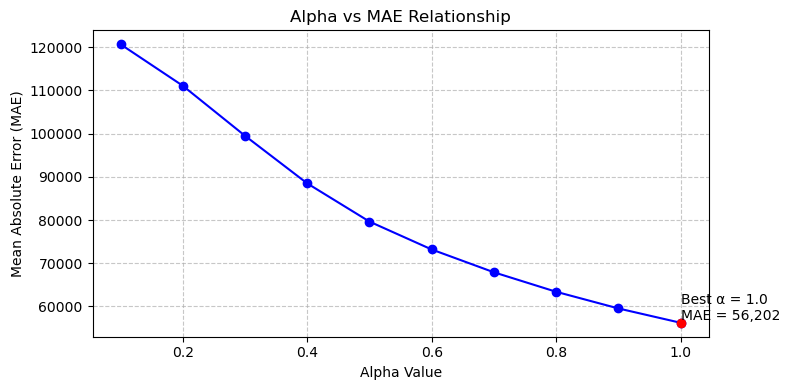

In [190]:
alpha_vals = np.arange(0.1, 1.1, 0.1)
print(f"Alpha Values: {alpha_vals}")
# Split data into training (75%) and testing (25%)
train_data, test_data = train_test_split(viewers_data, split_size=0.75)
alpha_wise_MAEs, best_alpha = test_alphas(alpha_vals, train_data)
plot_alpha_wise_MAE(alpha_wise_MAEs)

Mean Absolute Error for Simple Exponential Smoothing: 55530.79030054645


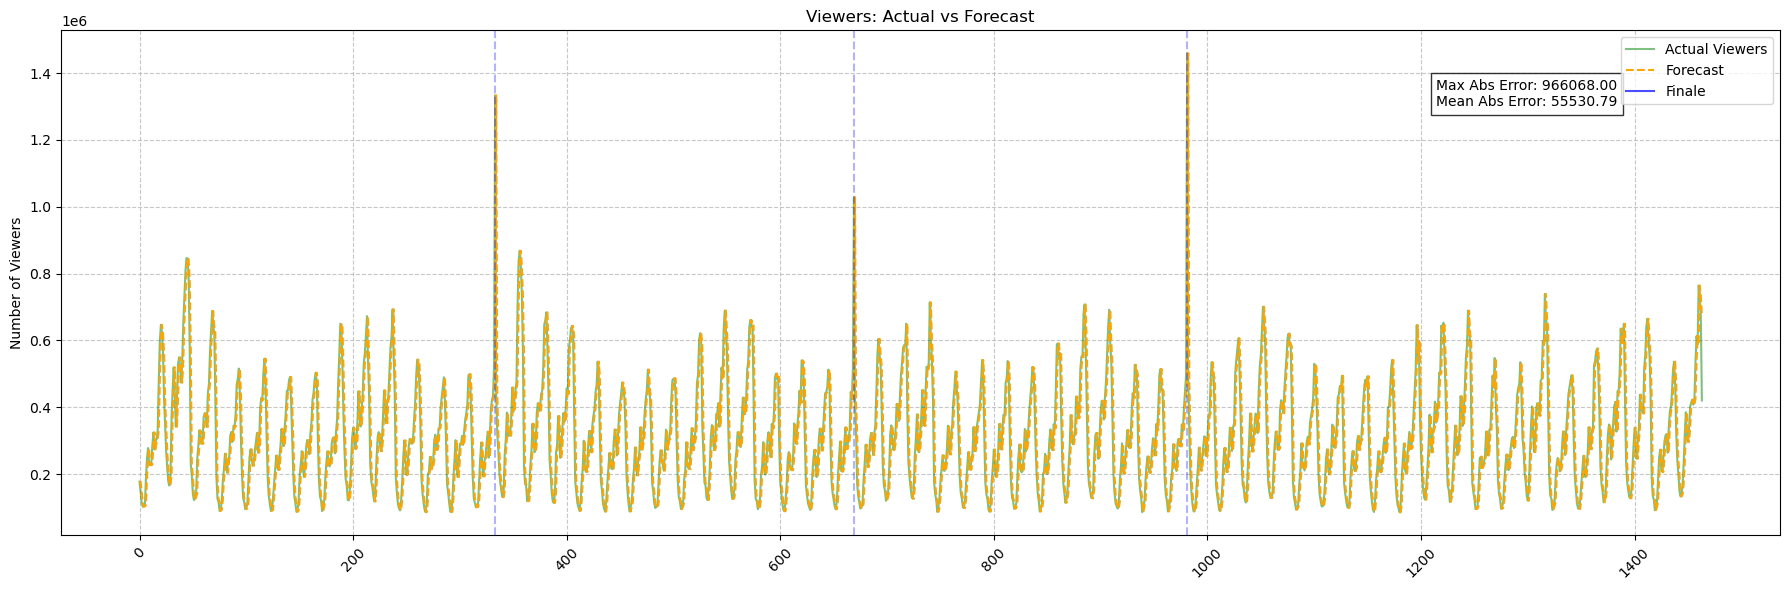

,date,hour,day_of_week,viewers,show_finale,holiday,sim_exp_smo_forecast,ses_error
0,2024-11-01,0,5,177140.0,0,0,177140.0,0.0
1,2024-11-01,1,5,148073.0,0,0,177140.0,-29067.0
2,2024-11-01,2,5,115361.0,0,0,148073.0,-32712.0
3,2024-11-01,3,5,102277.0,0,0,115361.0,-13084.0
4,2024-11-01,4,5,103369.0,0,0,102277.0,1092.0


In [191]:

viewers_data["sim_exp_smo_forecast"] = simple_exponential_smoothing(viewers_data['viewers'].values, best_alpha)
viewers_data["ses_error"] = viewers_data['viewers'] - viewers_data["sim_exp_smo_forecast"]
simple_exponential_smoothing_MAE = np.mean(abs(viewers_data['ses_error']))
print(f"Mean Absolute Error for Simple Exponential Smoothing: {simple_exponential_smoothing_MAE}")
plot_actual_vs_forecast(viewers_data['viewers'], viewers_data["sim_exp_smo_forecast"], viewers_data["ses_error"], viewers_data['show_finale'])

# final_forecast = (best_alpha * viewers_data['viewers'].iloc[-1]) + (1 - best_alpha) * viewers_data["Simple Exponential Smoothing Forecast"].iloc[-1]
viewers_data.head()

# DOUBLE EXPONENTIAL SMOOTHING - 

In [ ]:
# Level, Trend, Seasonal, Weekly Seasonality (7 * 24) smoothing
alpha, beta, gamma, seasonal_period = 0.3, 0.1, 0.2, 168

L = [viewers_data['viewers'].iloc[0]]
B = [(viewers_data['viewers'].iloc[1] - viewers_data['viewers'].iloc[0])]
S = [viewers_data['viewers']iloc[i] / (sum(viewers_data['viewers'][:seasonal_period]) / seasonal_period) for i in range(seasonal_period)]
